
# 📚 Book Recommendation Project — Data Cleaning & EDA

This notebook continues from our two scraping notebooks:

- `scrape_goodreads_best_books_ever.ipynb`
- `scrape_openLibrary_trending_api.ipynb`

We now:

1. Load & concatenate both datasets.
2. Clean & preprocess:
   - Remove duplicates & missing values
   - Normalize text (titles, genres, authors)
   - Convert genres to lists
   - Standardize ratings (0–5)
   - Extract simple keywords using TF-IDF
3. Exploratory Data Analysis (EDA):
   - Top rated books
   - Popular authors
   - Genre distribution
   - Rating patterns & correlations
   - Word cloud of frequent terms

In [348]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os

from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Optional wordcloud
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except:
    WORDCLOUD_AVAILABLE = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)


## 1. Load the two datasets


In [326]:
# Load Goodreads data
goodreads_path = "..\data\goodreads_best_books_600.csv"

if not os.path.exists(goodreads_path):
    goodreads_path = "goodreads_best_books_600.csv"
    
df_gr = pd.read_csv(goodreads_path)
print("Goodreads shape:", df_gr.shape)
df_gr.head(3)

Goodreads shape: (600, 11)


,rank,title,author,author_url,avg_rating,num_ratings,genres,year,score,votes,book_url
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,https://www.goodreads.com/author/show/153394.S...,4.35,9746939,"[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",2008.0,4282152,43534,https://www.goodreads.com/book/show/2767052-th...
1,2,Pride and Prejudice,Jane Austen,https://www.goodreads.com/author/show/1265.Jan...,4.29,4721836,"[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",1813.0,2945462,30186,https://www.goodreads.com/book/show/1885.Pride...
2,3,To Kill a Mockingbird,Harper Lee,https://www.goodreads.com/author/show/1825.Har...,4.26,6783823,"[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",1960.0,2588917,26436,https://www.goodreads.com/book/show/2657.To_Ki...


In [327]:
# Load Open Library data
openlib_path = "..\data\openlibrary_trending_600.csv"

if not os.path.exists(openlib_path):
    openlib_path = "openlibrary_trending_600.csv"

df_ol = pd.read_csv(openlib_path)
print("Open Library shape:", df_ol.shape)
df_ol.head(3)

Open Library shape: (600, 10)


,rank_in_page,title,author,author_url,avg_rating,num_ratings,year,score,book_url,genres
0,1,Kitchen Confidential,Anthony Bourdain,https://openlibrary.org/authors/OL543322A,4.04,49.0,2000.0,132,https://openlibrary.org/works/OL3348011W,"Cooks, Cocineros, History, New York Times best..."
1,2,Siddhartha,Hermann Hesse,https://openlibrary.org/authors/OL76437A,4.09,55.0,1922.0,254,https://openlibrary.org/works/OL872932W,"Alegorías, Buddha (The concept), Buddha and Bu..."
2,3,Silence,Shūsaku Endō,https://openlibrary.org/authors/OL4282449A,4.17,6.0,1980.0,91,https://openlibrary.org/works/OL15391655W,"Fiction, Christians, History, Missionaries in ..."



## 2. Add `source` column and align columns


In [328]:
df_gr["source"] = "goodreads"
df_ol["source"] = "openlibrary"

needed_cols = [
    "title",
    "author",
    "author_url",
    "avg_rating",
    "num_ratings",
    "year",
    "genres",
    "score",
    "votes",
    "book_url"
]

for col in needed_cols:
    if col not in df_gr.columns:
        df_gr[col] = np.nan
    if col not in df_ol.columns:
        df_ol[col] = np.nan


## 3. Concatenate


In [329]:
df = pd.concat([df_gr, df_ol], ignore_index=True)
print("Combined shape:", df.shape)
df.head(5)

Combined shape: (1200, 13)


,rank,title,author,author_url,avg_rating,num_ratings,genres,year,score,votes,book_url,source,rank_in_page
0,1.0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,https://www.goodreads.com/author/show/153394.S...,4.35,9746939.0,"[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",2008.0,4282152,43534.0,https://www.goodreads.com/book/show/2767052-th...,goodreads,NaN
1,2.0,Pride and Prejudice,Jane Austen,https://www.goodreads.com/author/show/1265.Jan...,4.29,4721836.0,"[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",1813.0,2945462,30186.0,https://www.goodreads.com/book/show/1885.Pride...,goodreads,NaN
2,3.0,To Kill a Mockingbird,Harper Lee,https://www.goodreads.com/author/show/1825.Har...,4.26,6783823.0,"[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",1960.0,2588917,26436.0,https://www.goodreads.com/book/show/2657.To_Ki...,goodreads,NaN
3,4.0,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,https://www.goodreads.com/author/show/1077326....,4.50,3744864.0,"[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",2003.0,2070264,21063.0,https://www.goodreads.com/book/show/58613451-h...,goodreads,NaN
4,5.0,The Book Thief,Markus Zusak,https://www.goodreads.com/author/show/11466.Ma...,4.39,2840007.0,"[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",2005.0,1957838,20110.0,https://www.goodreads.com/book/show/19063.The_...,goodreads,NaN


In [330]:
df.isnull().sum()

rank            600
title             0
author            2
author_url        2
avg_rating      104
num_ratings     104
genres           35
year             24
score             0
votes           600
book_url          0
source            0
rank_in_page    600
dtype: int64


## 4. Basic Cleaning: duplicates & missing


In [331]:
# Store original DataFrame before cleaning
df_original = df.copy()

# Identify rows that will be dropped due to missing title/author
rows_missing_title_author = df[df["title"].isna() | df["author"].isna()]

# Drop rows with missing title/author and create a proper copy
df_after_dropna = df.dropna(subset=["title", "author"]).copy()  # Added .copy()

# Drop irrelevant columns
df_after_dropna = df_after_dropna.drop(columns = ["rank", "rank_in_page", 'votes'])

# Clean title and author
df_after_dropna["title"] = df_after_dropna["title"].astype(str).str.strip()
df_after_dropna["author"] = df_after_dropna["author"].astype(str).str.strip()

# Collapse multiple spaces inside the string: "stephen    king" -> "stephen king"
df_after_dropna["author"] = df_after_dropna["author"].str.replace(r"\s+", " ", regex=True)
df_after_dropna["title"] = df_after_dropna["title"].str.replace(r"\s+", " ", regex=True)

# Lowercase helper columns for matching / duplicates
df_after_dropna["title_clean"] = df_after_dropna["title"].str.lower()
df_after_dropna["author_clean"] = df_after_dropna["author"].str.lower()

# Find duplicates
duplicate_mask = df_after_dropna.duplicated(subset=["title_clean", "author_clean"], keep='first')
duplicate_rows = df_after_dropna[duplicate_mask].copy()  # Added .copy()

# Final cleaned DataFrame
df_final = df_after_dropna.drop_duplicates(subset=["title_clean", "author_clean"])

# Create DataFrame with all dropped rows
dropped_rows = pd.concat([
    rows_missing_title_author.assign(drop_reason='missing_title_or_author'),
    duplicate_rows.assign(drop_reason='duplicate')
], ignore_index=True)

print(f"Original shape: {df_original.shape}")
print(f"Rows dropped due to missing title/author: {len(rows_missing_title_author)}")
print(f"Rows dropped due to duplicates: {len(duplicate_rows)}")
print(f"Total dropped rows: {len(dropped_rows)}")
print(f"Final cleaned shape: {df_final.shape}")

# Display dropped rows
print("\nDropped rows DataFrame:")
display(dropped_rows[['title', 'author', 'source', 'drop_reason']].head(5))

# Drop all rows with any missing values
df_no_missing = df_final.dropna()

print(f"Original shape: {df_final.shape}")
print(f"After dropping all rows with missing values: {df_no_missing.shape}")
print(f"Rows dropped: {df_final.shape[0] - df_no_missing.shape[0]}")

# Update df to the version without missing values
df = df_no_missing

Original shape: (1200, 13)
Rows dropped due to missing title/author: 2
Rows dropped due to duplicates: 27
Total dropped rows: 29
Final cleaned shape: (1171, 12)

Dropped rows DataFrame:


,title,author,source,drop_reason
0,As they saw the master,NaN,openlibrary,missing_title_or_author
1,Social studies Guyana,NaN,openlibrary,missing_title_or_author
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,goodreads,duplicate
3,To Kill a Mockingbird,Harper Lee,goodreads,duplicate
4,Fahrenheit 451,Ray Bradbury,goodreads,duplicate


Original shape: (1171, 12)
After dropping all rows with missing values: (1021, 12)
Rows dropped: 150


In [332]:
# Sanity Checks
df.isnull().sum()

title           0
author          0
author_url      0
avg_rating      0
num_ratings     0
genres          0
year            0
score           0
book_url        0
source          0
title_clean     0
author_clean    0
dtype: int64


## 5. Normalize genres


In [333]:
# Make sure we're working with a proper DataFrame copy
df = df.copy()

if "genres" not in df.columns:
    df["genres"] = np.nan

# Start by normalizing to string and stripping
df["genres"] = df["genres"].fillna("").astype(str).str.strip()

genres_list = []
for g in df["genres"]:
    # Lowercase
    g = g.lower()

    # Remove list-like brackets and quotes if they appear
    g = g.replace("[", " ").replace("]", " ").replace("'", " ")

    # Unify separators that behave like "and" / splitters
    g = g.replace("/", " ")
    g = g.replace("&", " ")
    g = g.replace("=", " ")
    g = g.replace("--", " ")
    g = g.replace("-", " ")

    # Collapse multiple spaces
    g = re.sub(r"\s+", " ", g).strip()

    if g == "":
        genres_list.append([])
    else:
        # Split mainly by comma (subjects/genres usually comma-separated)
        # raw_parts = [p.strip() for p in g.split(",")]
        raw_parts = [p.strip().lower() for p in g.split(",") if p.strip() != ""]

        final_parts = []
        for p in raw_parts:
            # Keep only letters and spaces (remove numbers, punctuation, codes)
            p = re.sub(r"[^a-z\s]", " ", p)
            p = re.sub(r"\s+", " ", p).strip()

            # Filter out empty / very short / junk-like tokens
            if p != "" and len(p) > 2:
                # Optional simple filter to drop obvious noise prefixes
                # e.g. "nyt", "collectionid", "pz" etc.
                if not p.startswith(("nyt", "collectionid", "pz")):
                    final_parts.append(p)

        # Remove duplicates while keeping order
        unique_parts = []
        for p in final_parts:
            if p not in unique_parts:
                unique_parts.append(p)

        genres_list.append(unique_parts)

df["genres_list"] = genres_list
df["genres_clean"] = df["genres_list"].apply(lambda x: ", ".join(x))
df[["genres", "genres_list"]].tail(15)

,genres,genres_list
1179,"Neanderthals, shamanism, sign language, taboos...","[neanderthals, shamanism, sign language, taboo..."
1181,"Business, Nonfiction, Industrial management, M...","[business, nonfiction, industrial management, ..."
1182,"Nutrition, Blacks, Nutritionally induced diseases","[nutrition, blacks, nutritionally induced dise..."
1184,"Operas, Librettos, Ballets, Scenarios, Vocal s...","[operas, librettos, ballets, scenarios, vocal ..."
1185,"Femmes, Conditions sociales, Discrimination à ...","[femmes, conditions sociales, discrimination l..."
1186,"Futures market, Commodity exchanges, Investments","[futures market, commodity exchanges, investme..."
1187,"African Americans, Relations with Jews, NEGRO-...","[african americans, relations with jews, negro..."
1188,"Spiritualism, Purgatory, Interviews","[spiritualism, purgatory, interviews]"
1190,"Fiction, Dungeons & Dragons Novel, Epic, Elves...","[fiction, dungeons dragons novel, epic, elves,..."
1191,"Conscience, Continental european fiction (fict...","[conscience, continental european fiction fict..."



## 6. Standardize ratings (0–5)


In [334]:
# Make sure we're working with a proper DataFrame copy
df = df.copy()

df["avg_rating"] = pd.to_numeric(df["avg_rating"], errors="coerce")

df["rating_0_5"] = df["avg_rating"]

mask_10 = (df["rating_0_5"] > 5) & (df["rating_0_5"] <= 10)
df.loc[mask_10, "rating_0_5"] = df.loc[mask_10, "rating_0_5"] / 2.0

df["rating_0_5"] = df["rating_0_5"].clip(lower=0, upper=5)

df[["avg_rating", "rating_0_5"]].head(10)

,avg_rating,rating_0_5
0,4.35,4.35
1,4.29,4.29
2,4.26,4.26
3,4.50,4.50
4,4.39,4.39
5,3.67,3.67
6,4.01,4.01
7,4.61,4.61
8,4.28,4.28
9,4.12,4.12



## 7. Clean `num_ratings`


In [335]:
# Make sure we're working with a proper DataFrame copy
df = df.copy()

df["num_ratings"] = pd.to_numeric(df["num_ratings"], errors="coerce").fillna(0)
df["num_ratings"] = df["num_ratings"].astype(int)
df[["title", "num_ratings"]].head(5)

,title,num_ratings
0,"The Hunger Games (The Hunger Games, #1)",9746939
1,Pride and Prejudice,4721836
2,To Kill a Mockingbird,6783823
3,Harry Potter and the Order of the Phoenix (Har...,3744864
4,The Book Thief,2840007



## 8. Text for TF-IDF Keywords


In [336]:
# Make sure we're working with a proper DataFrame copy
df = df.copy()

df["text_for_keywords"] = df["title"].fillna("").astype(str) + " " + df["genres"].fillna("").astype(str)
df["text_for_keywords"] = df["text_for_keywords"].str.lower()
df["text_for_keywords"].head(5)

0    the hunger games (the hunger games, #1) [['you...
1    pride and prejudice [['young adult', 'dystopia...
2    to kill a mockingbird [['young adult', 'dystop...
3    harry potter and the order of the phoenix (har...
4    the book thief [['young adult', 'dystopia', 'f...
Name: text_for_keywords, dtype: object


## 9. TF-IDF Keyword Extraction


In [337]:
max_features = 50

vectorizer = TfidfVectorizer(
    max_features=max_features,
    stop_words="english"
)

tfidf_matrix = vectorizer.fit_transform(df["text_for_keywords"])
feature_names = vectorizer.get_feature_names_out()

print("TF-IDF shape:", tfidf_matrix.shape)
print("Some features:", feature_names[:50])

TF-IDF shape: (1021, 50)
Some features: ['adult' 'adventure' 'age' 'audiobook' 'biography' 'book' 'books'
 'childrens' 'classics' 'club' 'coming' 'contemporary' 'crime' 'dystopia'
 'epic' 'fantasy' 'feminism' 'fiction' 'gothic' 'grade' 'harry' 'health'
 'high' 'historical' 'horror' 'humor' 'literature' 'magic' 'memoir'
 'mental' 'middle' 'mystery' 'mythology' 'novels' 'paranormal'
 'philosophy' 'picture' 'poetry' 'potter' 'read' 'romance' 'russia'
 'russian' 'school' 'science' 'thriller' 'travel' 'vampires' 'war' 'young']


In [338]:
top_keywords_list = []

for i in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix[i].toarray()[0]
    top_idx = row.argsort()[::-1]
    book_keywords = []
    for idx in top_idx:
        if row[idx] > 0:
            word = feature_names[idx]
            if word not in book_keywords:
                book_keywords.append(word)
        if len(book_keywords) >= 5:
            break
    top_keywords_list.append(", ".join(book_keywords))

df["top_keywords"] = top_keywords_list
df[["title", "top_keywords", "genres", "source"]].head(10)

,title,top_keywords,genres,source
0,"The Hunger Games (The Hunger Games, #1)","fiction, classics, fantasy, historical, adult","[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",goodreads
1,Pride and Prejudice,"fiction, classics, fantasy, historical, adult","[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",goodreads
2,To Kill a Mockingbird,"fiction, classics, fantasy, historical, adult","[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",goodreads
3,Harry Potter and the Order of the Phoenix (Har...,"fiction, classics, fantasy, historical, adult","[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",goodreads
4,The Book Thief,"fiction, classics, fantasy, historical, adult","[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",goodreads
5,"Twilight (The Twilight Saga, #1)","fiction, classics, fantasy, historical, adult","[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",goodreads
6,Animal Farm,"fiction, classics, fantasy, historical, adult","[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",goodreads
7,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,"fiction, classics, fantasy, historical, adult","[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",goodreads
8,The Chronicles of Narnia (The Chronicles of Na...,"fiction, classics, fantasy, historical, adult","[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",goodreads
9,The Fault in Our Stars,"fiction, classics, fantasy, historical, adult","[['Young Adult', 'Dystopia', 'Fiction', 'Fanta...",goodreads



## 10. Save cleaned dataset


In [339]:
# Save to CSV
output_path = "../data/books_merged_cleaned.csv"
df.to_csv(output_path, index=False, encoding="utf-8")
print("Saved:", output_path, "shape:", df.shape)

Saved: ../data/books_merged_cleaned.csv shape: (1021, 17)


In [340]:
df.columns

Index(['title', 'author', 'author_url', 'avg_rating', 'num_ratings', 'genres',
       'year', 'score', 'book_url', 'source', 'title_clean', 'author_clean',
       'genres_list', 'genres_clean', 'rating_0_5', 'text_for_keywords',
       'top_keywords'],
      dtype='object')


# 11. EDA
### 11.1 Rating distribution


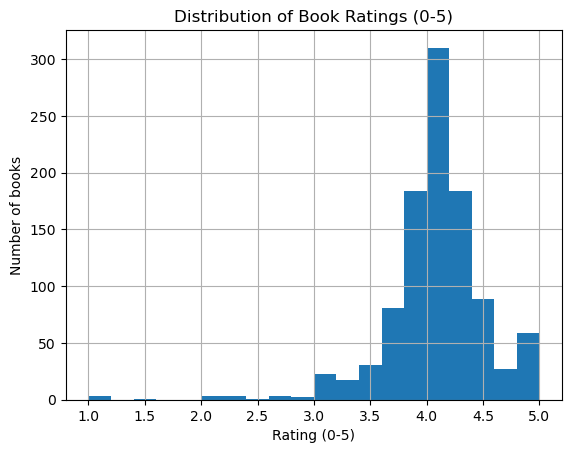

In [350]:
plt.figure()
df["rating_0_5"].hist(bins=20)
plt.xlabel("Rating (0-5)")
plt.ylabel("Number of books")
plt.title("Distribution of Book Ratings (0-5)")
plt.savefig("../figures/eda_rating_distribution.png", dpi=300)
plt.show()


### 11.2 Top authors


author_clean
stephen king       16
agatha christie    12
margaret way       11
j.k. rowling       10
rick riordan       10
j.r.r. tolkien      8
cassandra clare     8
sarah j. maas       8
jane austen         7
charles dickens     7
Name: count, dtype: int64


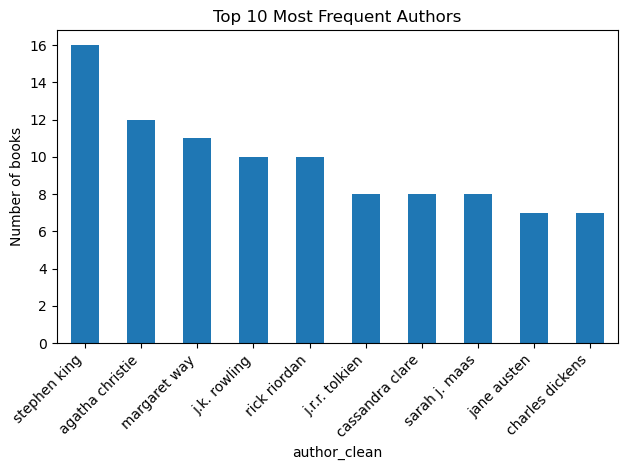

In [351]:
top_authors = df["author_clean"].value_counts().head(10)
print(top_authors)

plt.figure()
top_authors.plot(kind="bar")
plt.ylabel("Number of books")
plt.title("Top 10 Most Frequent Authors")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../figures/eda_top_authors.png", dpi=300)
plt.show()


### 11.3 Genre distribution


In [343]:
genre_counter = Counter()
for gen_list in df["genres_list"]:
    for g in gen_list:
        genre_counter[g] += 1

genre_counts = pd.Series(genre_counter).sort_values(ascending=False)
genre_counts.head(15)

fiction               813
history               639
romance               629
historical            606
fantasy               603
biography             602
contemporary          601
science fiction       601
philosophy            596
suspense              595
nonfiction            595
classic literature    592
psychology            592
horror                589
literature            587
dtype: int64

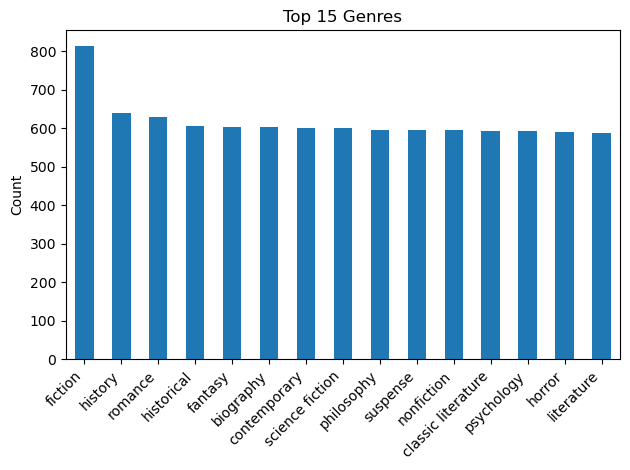

In [352]:
plt.figure()
genre_counts.head(15).plot(kind="bar")
plt.ylabel("Count")
plt.title("Top 15 Genres")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../figures/eda_top_genres.png", dpi=300)
plt.show()


### 11.4 Rating vs Number of Ratings


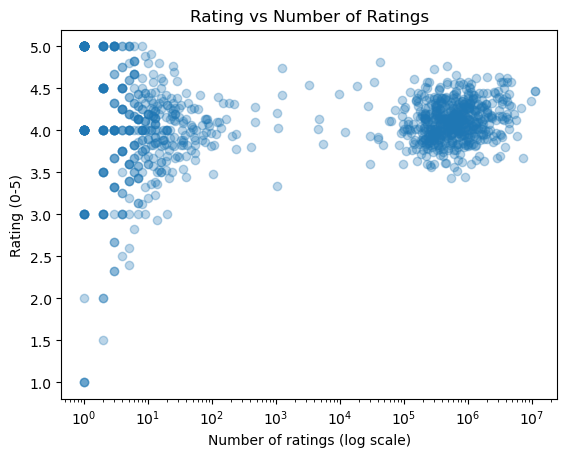

In [353]:
plt.figure()
plt.scatter(df["num_ratings"], df["rating_0_5"], alpha=0.3)
plt.xscale("log")
plt.xlabel("Number of ratings (log scale)")
plt.ylabel("Rating (0-5)")
plt.title("Rating vs Number of Ratings")
plt.savefig("../figures/eda_rating_vs_num_ratings.png", dpi=300)
plt.show()


### 11.5 Simple correlations


In [346]:
corr_cols = ["rating_0_5", "num_ratings", "score"]
existing = [c for c in corr_cols if c in df.columns]
df[existing].corr()

,rating_0_5,num_ratings,score
rating_0_5,1.000000,0.097733,0.072170
num_ratings,0.097733,1.000000,0.640385
score,0.072170,0.640385,1.000000



### 11.6 Word Cloud


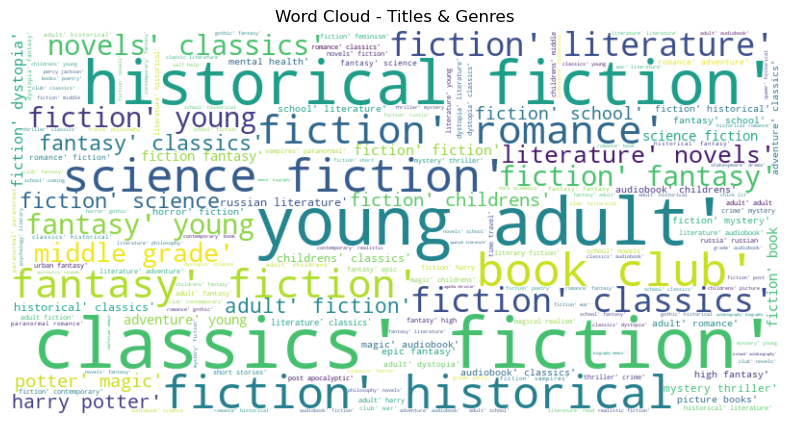

In [354]:
text_all = " ".join(df["text_for_keywords"].tolist())
wc = WordCloud(width=800, height=400, background_color="white").generate(text_all)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Titles & Genres")
plt.savefig("../figures/eda_wordcloud_titles_genres.png", dpi=300, bbox_inches="tight")
plt.show()